# Домашнее задание к вебинару 4
  
1. Обучите CNN (самописная) на CIFAR-100.  
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [143]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [116]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0] # достаем картинку по индексу
        if self.transform is not None:
            img = self.transform(img) # при наличии делаем трансформацию

        label = self._base_dataset[idx][1] #достаем класс по индексу

        return img, label

Files already downloaded and verified


In [117]:
# Определим необходимые трансформации в композицию
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

# Сделаем разбиение на тренировочную и тестовую выборки
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [118]:
# Создаем dataloader-ы (итераторы данных датасета)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [119]:
classes = dataset.classes
print(f'Всего классов : {len(classes)} \n' \
      f'Примеры классов: {classes[:5] + classes[-5:]}')

Всего классов : 100 
Примеры классов: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


torch.Size([128, 3, 32, 32])
telephone


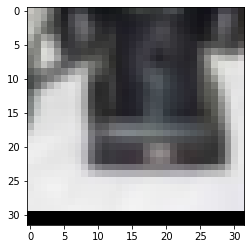

In [120]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.size())
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Самописная нейронная сеть

In [122]:
torch.manual_seed(10)

In [140]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.dp_1 = nn.Dropout(0.5)
        self.dp_2 = nn.Dropout(0.2)
        
        # 1 слой
        self.bn_1 = torch.nn.BatchNorm2d(3) 
        self.conv_1= torch.nn.Conv2d(3, 64, 3, padding=1, padding_mode='zeros')

        # 2 слой
        self.bn_2 = torch.nn.BatchNorm2d(64) 
        self.conv_2= torch.nn.Conv2d(64, 128, 3, padding=1, padding_mode='zeros')

        # 3 слой
        self.bn_3 = torch.nn.BatchNorm2d(128) 
        self.conv_3 = torch.nn.Conv2d(128, 256, 3, padding=1, padding_mode='zeros')

        # 4 слой
        self.bn_4 = torch.nn.BatchNorm2d(256)
        self.conv_4 = torch.nn.Conv2d(256, 512, 3, padding=1, padding_mode='zeros')

        # Полносвязные слои
        self.bn_5 = torch.nn.BatchNorm2d(512)
        self.fc_1 = torch.nn.Linear(2048, 1024)
        self.out = torch.nn.Linear(1024, 100)
        
    def forward(self, x):
        x = self.bn_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.dp_1(x)
        
        x = self.bn_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.dp_1(x)
        
        x = self.bn_3(x)
        x = self.conv_3(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        # x = self.dp_1(x)

        x = self.bn_4(x)
        x = self.conv_4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_5(x)
        x = x.view(x.size(0), -1) # аналог flatten, вытягиваем картинку в один вектор
        # x = self.dp_2(x)
        x = self.fc_1(x)
        x = F.relu(x)

        return self.out(x)
       
net = Net().to(device)

from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 32, 32]           1,792
       BatchNorm2d-3           [-1, 64, 16, 16]             128
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5            [-1, 128, 8, 8]             256
            Conv2d-6            [-1, 256, 8, 8]         295,168
       BatchNorm2d-7            [-1, 256, 4, 4]             512
            Conv2d-8            [-1, 512, 4, 4]       1,180,160
       BatchNorm2d-9            [-1, 512, 2, 2]           1,024
           Linear-10                 [-1, 1024]       2,098,176
           Linear-11                  [-1, 100]         102,500
Total params: 3,753,578
Trainable params: 3,753,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [141]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [142]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.023. Test acc: 0.006
Epoch [1/10]. Step [301/372]. Loss: 0.042. Acc: 0.028. Test acc: 0.052
Epoch [2/10]. Step [1/372]. Loss: 0.033. Acc: 0.062. Test acc: 0.036
Epoch [2/10]. Step [301/372]. Loss: 0.033. Acc: 0.050. Test acc: 0.054
Epoch [3/10]. Step [1/372]. Loss: 0.032. Acc: 0.078. Test acc: 0.050
Epoch [3/10]. Step [301/372]. Loss: 0.032. Acc: 0.064. Test acc: 0.066
Epoch [4/10]. Step [1/372]. Loss: 0.030. Acc: 0.102. Test acc: 0.082
Epoch [4/10]. Step [301/372]. Loss: 0.030. Acc: 0.089. Test acc: 0.082
Epoch [5/10]. Step [1/372]. Loss: 0.029. Acc: 0.117. Test acc: 0.058
Epoch [5/10]. Step [301/372]. Loss: 0.030. Acc: 0.106. Test acc: 0.106
Epoch [6/10]. Step [1/372]. Loss: 0.030. Acc: 0.070. Test acc: 0.084
Epoch [6/10]. Step [301/372]. Loss: 0.029. Acc: 0.125. Test acc: 0.106
Epoch [7/10]. Step [1/372]. Loss: 0.029. Acc: 0.125. Test acc: 0.129
Epoch [7/10]. Step [301/372]. Loss: 0.027. Acc: 0.148. Test acc: 0.141
Epoch [8/10]. Step [

Модель слабая, дополнительно исключила из сети Dropout, но результат все равно низкий.

### 2. Предобученная нейронная сеть ResNet50 (ImageNet)

In [144]:
# загрузка предобученной модели resnet50
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [145]:
# отключим обучение уже предобученных слоев:

for param in resnet50.parameters():
    param.requires_grad = False

In [162]:
# Необходимо переопределить последний слой, т.к. он размерностью не совпадает с задачей

resnet50.fc = torch.nn.Linear(2048, 100)

for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

Таким образом обучаются только последние 2 слоя

In [165]:
# Посмотрим всю модель целиком
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [174]:
# Определим необходимые трансформации в композицию
train_transforms = transforms.Compose([transforms.Resize(50), 
                                    transforms.RandomCrop(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
])

# Определим необходимые трансформации в композицию
test_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
])

# переопределим тренировочный и тестовый датасет с учетом новой трансформации
train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_transforms)
valid_dataset = MyOwnCifar(valid_dataset, test_transforms)

In [175]:
# Переопределим dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [176]:
# Собираем в список обучаемые параметры

# список весов для обновления
params_to_update = []

# собираем рапаметры (веса), у которых param.requires_grad == True
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[ 0.0115,  0.0048,  0.0004,  ...,  0.0191, -0.0199, -0.0013],
         [ 0.0184, -0.0181,  0.0097,  ..., -0.0171,  0.0049, -0.0009],
         [-0.0214, -0.0124,  0.0143,  ..., -0.0117,  0.0071, -0.0195],
         ...,
         [-0.0207, -0.0102, -0.0115,  ..., -0.0093,  0.0064,  0.0141],
         [-0.0185, -0.0086, -0.0131,  ..., -0.0180,  0.0069,  0.0034],
         [-0.0080,  0.0219,  0.0156,  ...,  0.0079,  0.0002,  0.0036]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 5.0298e-03,  9.8429e-03, -1.0381e-02,  1.2073e-02, -7.2136e-03,
          1.1398e-02, -1.0667e-02, -1.0305e-02,  1.0171e-03, -1.8549e-02,
          9.8556e-04,  6.6351e-03,  1.9900e-02, -7.7324e-03, -1.3898e-02,
          1.1787e-02, -2.1573e-02, -1.3318e-02, -1.5384e-02,  2.8458e-03,
          5.9575e-03,  4.3653e-03,  5.0787e-03,  2.0377e-02,  9.7145e-03,
          3.4228e-03, -1.4831e-02,  1.2940e-02, -2.1790e-02, -1.4180e-02,
         -1.3334e-02, -9

In [177]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

In [179]:
#Обучение сети

epochs = 13

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.066. Acc: 0.148. Test acc: 0.169
Epoch [1/10]. Step [301/372]. Loss: 0.056. Acc: 0.243. Test acc: 0.202
Epoch [2/10]. Step [1/372]. Loss: 0.057. Acc: 0.281. Test acc: 0.191
Epoch [2/10]. Step [301/372]. Loss: 0.057. Acc: 0.239. Test acc: 0.209
Epoch [3/10]. Step [1/372]. Loss: 0.056. Acc: 0.266. Test acc: 0.177
Epoch [3/10]. Step [301/372]. Loss: 0.057. Acc: 0.241. Test acc: 0.208
Epoch [4/10]. Step [1/372]. Loss: 0.051. Acc: 0.281. Test acc: 0.196
Epoch [4/10]. Step [301/372]. Loss: 0.058. Acc: 0.239. Test acc: 0.204
Epoch [5/10]. Step [1/372]. Loss: 0.056. Acc: 0.203. Test acc: 0.184
Epoch [5/10]. Step [301/372]. Loss: 0.059. Acc: 0.243. Test acc: 0.209
Epoch [6/10]. Step [1/372]. Loss: 0.061. Acc: 0.211. Test acc: 0.188
Epoch [6/10]. Step [301/372]. Loss: 0.059. Acc: 0.249. Test acc: 0.203
Epoch [7/10]. Step [1/372]. Loss: 0.057. Acc: 0.266. Test acc: 0.190
Epoch [7/10]. Step [301/372]. Loss: 0.060. Acc: 0.247. Test acc: 0.212
Epoch [8/10]. Step [

Результат у предобученной сети очевидно лучше.